In [2]:
!pip install gym

     |████████████████████████████████| 1.6 MB 2.0 MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.20.0-py3-none-any.whl size=1650481 sha256=1187ad86a715f5a763c496ca19461f43811b54c08ff42ed9c6902ac57029368c
  Stored in directory: /Users/vinay/Library/Caches/pip/wheels/9f/91/e5/ac160083c57e371f1137b11482894fca821597dc5961fb9e8c
Successfully built gym


In [178]:
import math

from gym import Env as OpenAIEnv
from gym import spaces
from IPython.display import HTML
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import numpy as np

## Assignment 1 - Defining & Solving RL Environment

In [405]:
class GridEnv(OpenAIEnv):
    def __init__(self, is_stochastic, action_transitions, w=4, h=5, max_timesteps=70):
        self.w = w
        self.h = h
        self.is_stochastic = is_stochastic
        self.actions = list(action_transitions)
        self.action_transitions = action_transitions
        self.current_action = None
        self.observation_space = spaces.Discrete(w*h)
        self.action_space = spaces.Discrete(len(self.actions))
        self.max_timesteps = max_timesteps
        self.timestep = 0
        self.state = np.zeros((self.h, self.w))
        self.agent_pos = np.array([0, 0])
        
        # set random goal position
        self.goal_pos = np.array([np.random.choice(h), np.random.choice(w)])
        
        # set colors for visualization
        self.state[tuple(self.agent_pos)] = 0.4
        self.state[tuple(self.goal_pos)] = 1
        
        # set all possible actions
        self.action_domain = self.actions
        
        self.base_reward = int((self._get_distance(
            np.array(self.agent_pos),
            np.array(self.goal_pos),
        ) * 10))
        
        self.max_reward = int((self._get_distance(
            np.array([0, 0]),
            np.array([self.h, self.w]),
        ) * 10))
        
        fig, ax, mesh = self._set_figure(
            self.state,
            self.w,
            self.h,
            self.observation_space.n,
            len(self.actions),
        )
        
    @staticmethod
    def _set_figure(grid, w, h, states, actions, n=1, m=1, figsize=(5, 5)):
        fig, ax = plt.subplots(n, m, figsize=figsize)
        mesh = []
        
        if n == 1 and m == 1:
            # Set grid size
            ax.set_xticks(np.arange(0, w, 1))
            ax.set_yticks(np.arange(0, h, 1))
            mesh.append(ax.pcolormesh(grid, cmap ='Greens'))
            plt.grid()
        else:
            for i in range(n):
                for j in range(m):
                    ax[i][j].set_xticks(np.arange(0, w, 1))
                    ax[i][j].set_yticks(np.arange(0, h, 1))
                    mesh.append(ax[i][j].pcolormesh(grid, cmap ='Greens'))
                    ax[i][j].grid()
                    
        plt.title(
                f'#states: {states}, #actions: {actions}',
                y=-0.01,
                color='gray',
            )
        
        return fig, ax, mesh
        
    @staticmethod
    def _get_distance(X, Y):
        return np.linalg.norm(X - Y)
    
    def _render_plots(self, n, m, figsize):
        fig, ax, mesh = self._set_figure(
            self.state,
            self.w,
            self.h,
            self.observation_space.n,
            len(self.actions),
            n,
            m,
            figsize, 
        )
        count = 0
        for i in range(n):
            for j in range(m):
                self._update_fig(_, mesh[count], ax[i][j])
                count += 1
        
        plt.show()
        
    
    def _update_fig(self, i, mesh, ax):
        action, performed, reward = self.step()
        mesh.set_array(self.state.flatten())
        ax.set_title(
            f'timestep: {self.timestep} | reward: {reward} | action: {action}({"True" if performed else "False"})'
        )
        return mesh
    
    def _perform_action(self, action):
        self.current_action = action
        will_move = True
        if self.is_stochastic:
            # make a move according to the transition probability 
            rand = np.random.uniform(0, 1, 1)
            will_move = True if rand < self.action_transitions[action] else False
            
        if action.lower() == 'w':
            # move upwards if 
            self.agent_pos[0] += 1 if will_move else 0
        elif action.lower() == 's':
            # move downwards
            self.agent_pos[0] -= 1 if will_move else 0
        elif action.lower() == 'a':
            # move left
            self.agent_pos[1] -= 1 if will_move else 0
        elif action.lower() == 'd':
            # move right
            self.agent_pos[1] += 1 if will_move else 0
        
        # clip out of bound positions to the edges
        self.agent_pos[0] = self.h-1 if self.agent_pos[0] >= self.h else max(0, self.agent_pos[0])
        self.agent_pos[1] = self.w-1 if self.agent_pos[1] >= self.w else max(0, self.agent_pos[1])
        
        return will_move
        
    def reset(self):
        self.time_step = 0
        self.agent_pos = np.array([0, 0])
        self.state = np.zeros((self.h, self.w))
        observation = self.state.flatten()
        
        return observation
    
    def step(self, action=None):
        if not action:
            # select random action if no action is provided
            action_idx = np.random.choice(self.action_space.n)
            action = self.action_domain[action_idx]
        elif action not in self.action_domain:
            raise Exception('Action not defined for current environment')
        
        # erase old agent position
        self.state[tuple(self.agent_pos)] = 0
        action_performed = self._perform_action(action)
        
        # set colors for visualization
        self.state[tuple(self.agent_pos)] = 0.4
        self.state[tuple(self.goal_pos)] = 1
        d = int(self._get_distance(self.agent_pos, self.goal_pos) * 10)
        
        # assign reward as a function of distance from goal
        reward = self.max_reward - d - self.base_reward
        self.timestep += 1
        
        return action, action_performed, reward
    
    def render(self):
        fig, ax, mesh = self._set_figure(
            self.state,
            self.w,
            self.h,
            self.observation_space.n,
            len(self.actions),
        )
        plt.show()
        
    def animate(self):
        fig, ax, mesh = self._set_figure(
            self.state,
            self.w,
            self.h,
            self.observation_space.n,
            len(self.actions),
        )
        ani = FuncAnimation(
            fig,
            self._update_fig,
            frames=self.max_timesteps,
            interval=160,
            fargs=(mesh[0], ax, ), 
        )
        ani.save('quiz1-animation.mp4')
        return ani

## Stochastic Environment

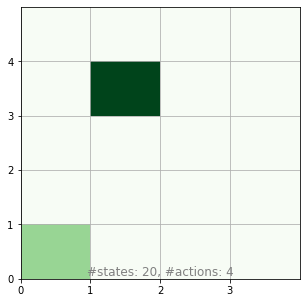

In [406]:
stochastic_env = GridEnv(
    w=4,
    h=5,
    max_timesteps=100,
    is_stochastic=True,
    action_transitions={
        'w': 0.85,
        's': 0.88,
        'd': 0.86,
        'a': 0.89,
    }
)

### Render #n timesteps

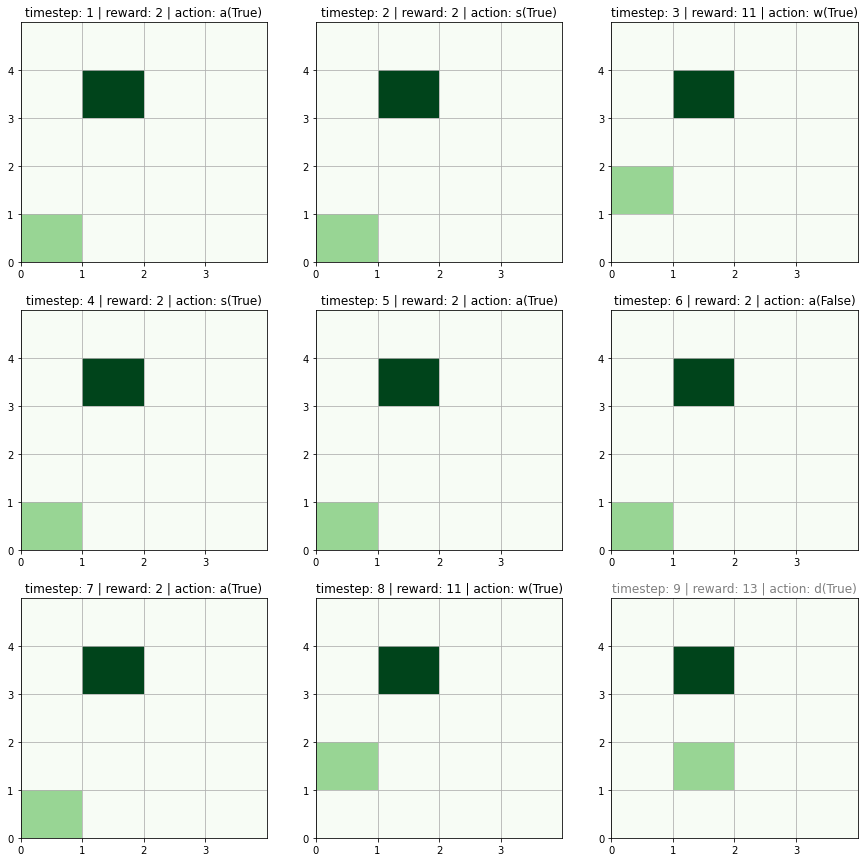

In [407]:
stochastic_env._render_plots(3, 3, figsize=(15, 15))

### Animation

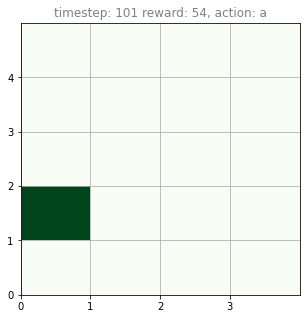

In [408]:
# saves in the same directory with name 'quiz1-animation.mp4'
ani = env.animate()

In [409]:
# display animation
HTML(ani.to_html5_video())

### Render grid manually

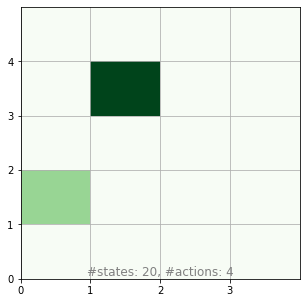

Action: a, Action Performed: True, Reward: 11


In [410]:
# random action will be selected if no action is passed to the step function
action, is_action_performed, reward = stochastic_env.step()
stochastic_env.render()
print(f'Action: {action}, Action Performed: {is_action_performed}, Reward: {reward}')

## Deterministic Environment

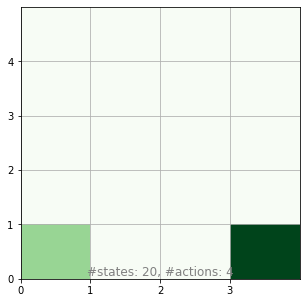

In [411]:
deterministic_env = GridEnv(
    w=4,
    h=5,
    max_timesteps=100,
    is_stochastic=False,
    action_transitions={
        'w': 1,
        's': 1,
        'd': 1,
        'a': 1,
    }
)

### Render #n timesteps

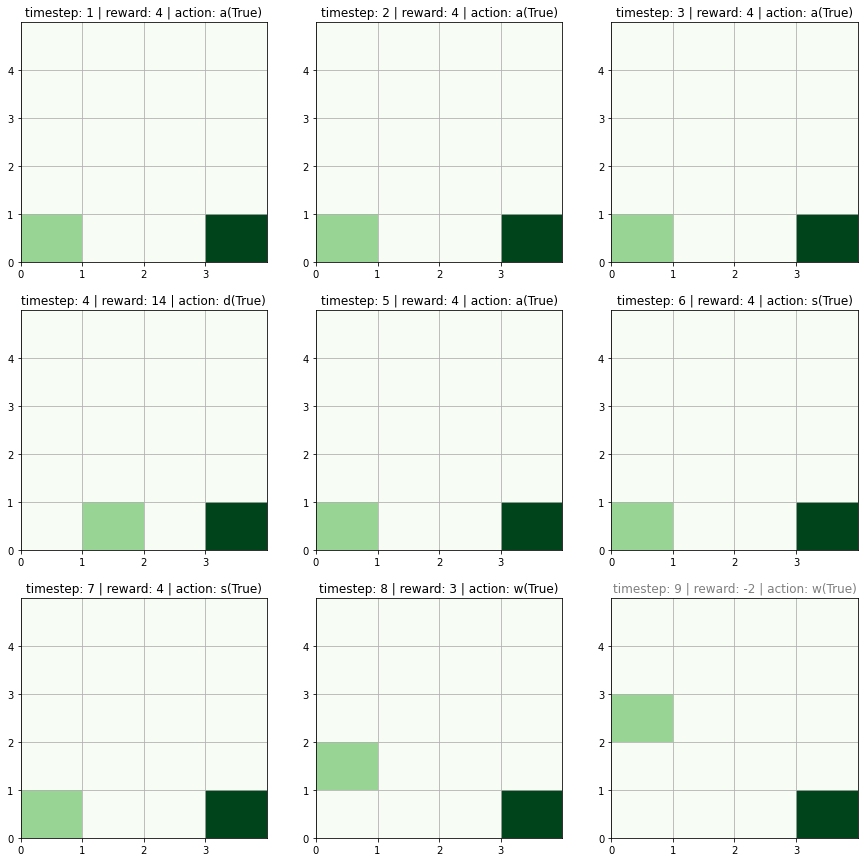

In [412]:
deterministic_env._render_plots(3, 3, figsize=(15, 15))

### Render grid manually

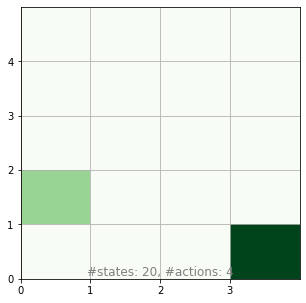

Action: s, Action Performed: True, Reward: 3


In [413]:
# random action will be selected if no action is passed to the step function
action, is_action_performed, reward = deterministic_env.step(action='s')
deterministic_env.render()
print(f'Action: {action}, Action Performed: {is_action_performed}, Reward: {reward}')